<a href="https://colab.research.google.com/github/shelviaandi/TFLite_Experiments/blob/master/Fashion_MNIST_TFLite.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

import numpy as np
import matplotlib.pyplot as plt
import pathlib

from os import getcwd

print('\u2022 using TensorFlow Version: ', tf.__version__)
print('\u2022 GPU Device Found.' if tf.test.is_gpu_available() else '\u2022 GPU Device Not Found. Running on CPU')

• using TensorFlow Version:  2.3.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
• GPU Device Found.


## Download Fashion MNIST Dataset

In [ ]:
#splits = tfds.Split.ALL.subsplit(weighted=(80, 10, 10))

#filePath = f"{getcwd()}/../tmp2/"
#splits, info = tfds.load('fashion_mnist', with_info=True, as_supervised=True, split=splits, data_dir=filePath)

#(train_examples, validation_examples, test_examples) = splits

#num_examples = info.splits['train'].num_examples
#num_classes = info.features['label'].num_classes

In [19]:
filePath = f"{getcwd()}/../tmp2/"
train_ds = tfds.load('fashion_mnist', split='train')
train_examples, info = tfds.load('fashion_mnist', split='train[:54000]',  with_info=True, as_supervised=True, data_dir = filePath)
validation_examples, info = tfds.load('fashion_mnist', split='train[54000:]',  with_info=True, as_supervised=True, data_dir = filePath)
test_examples, info = tfds.load('fashion_mnist', split='test',  with_info=True, as_supervised=True, data_dir = filePath)

In [3]:
def dataset_length(dataset):
    count = 0
    for image in dataset:
        count += 1
    return count

In [4]:
dataset_length(validation_examples)

6000

In [6]:
num_examples = info.splits['train'].num_examples
num_examples

60000

In [8]:
num_classes = info.features['label'].num_classes
num_classes

10

In [16]:
sample = next(iter(train_examples))
sample[0].shape

TensorShape([28, 28, 1])

In [17]:
sample[1]

<tf.Tensor: shape=(), dtype=int64, numpy=2>

In [7]:
class_names = ['T-shirt_top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [9]:
# create a labels.txt file with the class names
with open('labels.txt', 'w') as f:
  f.write('\n'.join(class_names)) 

In [ ]:
#from google.colab import files
#files.download('labels.txt')

In [10]:
IMG_SIZE = 28

## Preprocessing Data

### Preprocess

In [11]:
def format_example(image, label):
  # Cast image to float 32
  image = tf.cast(image, dtype=tf.float32)
  #Normalize the image in the range [0. 1]
  image = image/255.0
  label = tf.one_hot(label, num_classes)
  return image, label

In [12]:
BATCH_SIZE = 256

## Create Datasets from Images and Labels

In [14]:
# Create Datasets
train_batches = train_examples.cache().shuffle(num_examples//4).batch(BATCH_SIZE).map(format_example).prefetch(1)
validation_batches = validation_examples.cache().batch(BATCH_SIZE).map(format_example)
test_batches = test_examples.map(format_example).batch(1)

In [21]:
batch_sample = next(iter(train_batches))

In [ ]:
#tf.squeeze(batch_sample[0][0]).numpy()

In [24]:
batch_sample[0][0].numpy().argmax()

47

In [25]:
def show_batch(x,y,shape = None):
    """
    input: 
        x(Tensor[num_images, rows, columns]): images tensor
        y(array): labels
        shape(tuple): (rows,col) 
    output:
        grid of smaple images
    """

    if not shape:
        shape = (int(x.shape[0]**0.5), int(x.shape[0]**0.5))

    fig, axs = plt.subplots(nrows= shape[0], ncols=shape[1], figsize = (12,8))
    index = 0
    for row in axs:
        for ax in row:
            ax.imshow(tf.squeeze(x[index]).numpy())
            ax.set_xlabel(class_names[y[index].numpy().argmax()])
            index+=1

    # plt.subplots_adjust(wspace = 0.2, hspace = 0.5) 
    fig.tight_layout()
    plt.show()

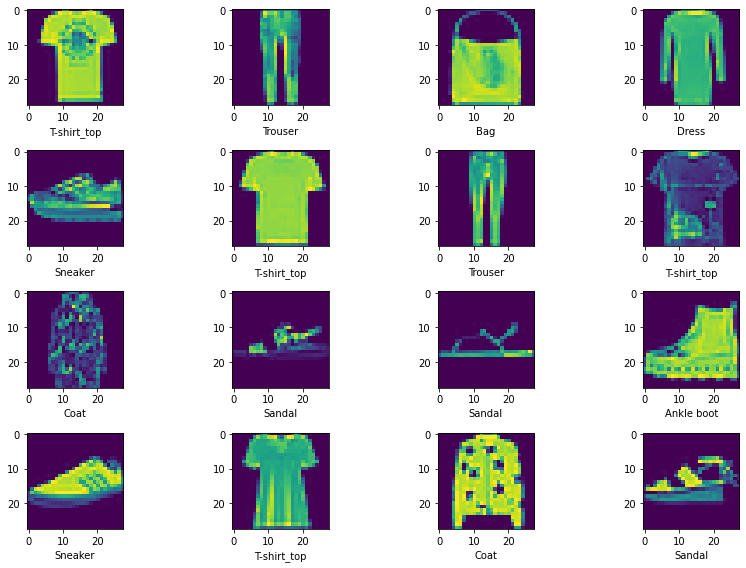

In [29]:
show_batch(batch_sample[0], batch_sample[1], (4, 4))

## Building the Model

In [30]:
model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(28,28,1)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics = ['accuracy'])

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 32)        4640      
_________________________________________________________________
flatten (Flatten)            (None, 3872)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                247872    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                650       
Total params: 253,322
Trainable params: 253,322
Non-trainable params: 0
__________________________________________________

In [32]:
history = model.fit(train_batches, epochs=10, validation_data= validation_batches)

Epoch 1/10
211/211 [==============================] - 7s 31ms/step - loss: 0.5986 - accuracy: 0.7890 - val_loss: 0.3928 - val_accuracy: 0.8605
Epoch 2/10
211/211 [==============================] - 1s 5ms/step - loss: 0.3768 - accuracy: 0.8668 - val_loss: 0.3416 - val_accuracy: 0.8802
Epoch 3/10
211/211 [==============================] - 1s 5ms/step - loss: 0.3298 - accuracy: 0.8830 - val_loss: 0.3143 - val_accuracy: 0.8857
Epoch 4/10
211/211 [==============================] - 1s 5ms/step - loss: 0.2965 - accuracy: 0.8955 - val_loss: 0.2900 - val_accuracy: 0.8958
Epoch 5/10
211/211 [==============================] - 1s 5ms/step - loss: 0.2766 - accuracy: 0.9023 - val_loss: 0.2755 - val_accuracy: 0.9017
Epoch 6/10
211/211 [==============================] - 1s 5ms/step - loss: 0.2600 - accuracy: 0.9054 - val_loss: 0.2775 - val_accuracy: 0.9025
Epoch 7/10
211/211 [==============================] - 1s 5ms/step - loss: 0.2489 - accuracy: 0.9099 - val_loss: 0.2748 - val_accuracy: 0.9018
Epoch

## Exporting to TFLite

In [34]:
# Use tf.saved_model API to save the model in the SavedModel format
export_dir = 'saved_model/1'

tf.saved_model.save(model, export_dir)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


INFO:tensorflow:Assets written to: saved_model/1/assets


INFO:tensorflow:Assets written to: saved_model/1/assets


In [35]:
# Select mode of optimization
mode = "Speed"

if mode == 'Storage':
  optimization = tf.lite.Optimize.OPTIMIZE_FOR_SIZE
elif mode == 'Speed':
  optimization = tf.lite.Optimize.OPTIMIZE_FOR_LATENCY
else:
  optimization = tf.lite.Optimize.DEFAULT

In [36]:
# Use TFLiteConverter SavedModel API to initialize the converter
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)

# Set the optimization
converter.optimizations = [optimization]

# Invoke the converter to finally generate the TFLite model
tflite_model = converter.convert()

In [37]:
tflite_model_file = pathlib.Path('./model.tflite')
tflite_model_file.write_bytes(tflite_model)

259664

## Test the Model with TFLite Interpreter

In [38]:
# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

In [39]:
# Gather results for the randomly sampled test images
predictions = []
test_labels = []
test_images = []

for img, label in test_batches.take(50):
  interpreter.set_tensor(input_index, img)
  interpreter.invoke()
  predictions.append(interpreter.get_tensor(output_index))
  test_labels.append(label[0])
  test_images.append(np.array(img))

In [51]:
#class_names

In [46]:
#@title Utility functions for plotting
# Utilities for plotting

def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    img = np.squeeze(img)

    plt.imshow(img, cmap = plt.cm.binary)

    predicted_label = np.argmax(predictions_array)

    if predicted_label == true_label.numpy().argmax():
        color = 'green'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                         100*np.max(predictions_array),
                                         class_names[true_label.numpy().argmax()]),
                                         color=color)
    
def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array[i], true_label[i]
    plt.grid(False)
    plt.xticks(list(range(10)), class_names, rotation='vertical')
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array[0], color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array[0])

    thisplot[predicted_label].set_color('red')
    thisplot[true_label.numpy().argmax()].set_color('green')

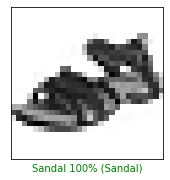

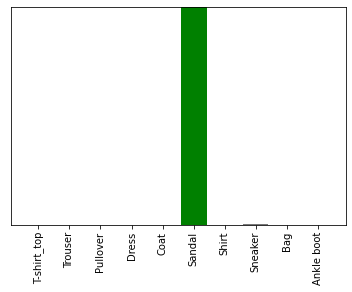

In [50]:
#@title Visualize the outputs {run: "auto"}
index = 33 #@param {type:"slider", min:1, max:50, step:1}
plt.figure(figsize=(6,3))
plt.subplot(1, 2, 1)
plot_image(index, predictions, test_labels, test_images)
plt.show()
plot_value_array(index, predictions, test_labels)
plt.show()